In [1]:
import os
import pandas as pd
import re
import numpy as np
from multiprocessing import Pool, cpu_count
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from transformers import AutoTokenizer, BertForSequenceClassification, BertTokenizer
from xgboost import XGBClassifier



In [2]:
# !pip install xgboost
# ! pip install transformers
# !pip install wordcloud
# !pip install tqdm

In [3]:
# Read the CSV file from the URL
df = pd.read_csv('https://raw.githubusercontent.com/lunapapa-finland/EDISS-NLP/main/data/processed_data.csv')

if False:
    
    df_raw = pd.read_csv('../data/Sentiment140.tenPercent.sample.tweets.tsv', sep='\t')

    def preprocess_text(text):
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove TAGs
        text = re.sub(r'@\w+', '', text)

        # Remove abbreviations
        text = re.sub(r'\b\'ll\b', ' will', text)
        text = re.sub(r'\b\'s\b', ' is', text)
        text = re.sub(r'\b\'re\b', ' are', text)
        text = re.sub(r'\b\'d\b', ' would', text)
        text = re.sub(r'\b\'m\b', ' am', text)
        text = re.sub(r'\b\'ve\b', ' have', text)
        # Remove special characters
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Replace more than one space with a single space
        text = re.sub(r'\s+', ' ', text)
        # Trim text with space before and after
        text = text.strip()
        # Convert to lowercase
        text = text.lower()
        return text

    def preprocess_wrapper(args):
        index, row = args
        row['tweet_text_processed'] = preprocess_text(row['tweet_text'])
        return row

    # Apply preprocess_text() to each row using multiprocessing
    num_processes = cpu_count()  # Number of CPU cores
    print(f'{num_processes} cores are using to process the data for accelerating processing time.')

    with Pool(processes=num_processes) as pool:
        result = list(tqdm(pool.imap(preprocess_wrapper, df_raw.iterrows()), total=len(df_raw)))

    # Convert the list of processed rows back to a DataFrame
    df = pd.DataFrame(result)


# Print the original and processed tweet content for the first 10 samples
for index, row in df.head(3).iterrows():
    print(f"For {index} sample, the processed tweet content is: {row['tweet_text_processed']}")

For 0 sample, the processed tweet content is: hey dear happy friday to you already had your rice is bowl for lunch
For 1 sample, the processed tweet content is: ughhh layin downnnn waiting for zeina to cook breakfast
For 2 sample, the processed tweet content is: i reckon he will play even if he is not but i know nothing it wont be the same without him


In [4]:
df.dropna(subset=['tweet_text_processed'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159653 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   sentiment_label       159653 non-null  int64 
 1   tweet_text_processed  159653 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


Positive Cloud


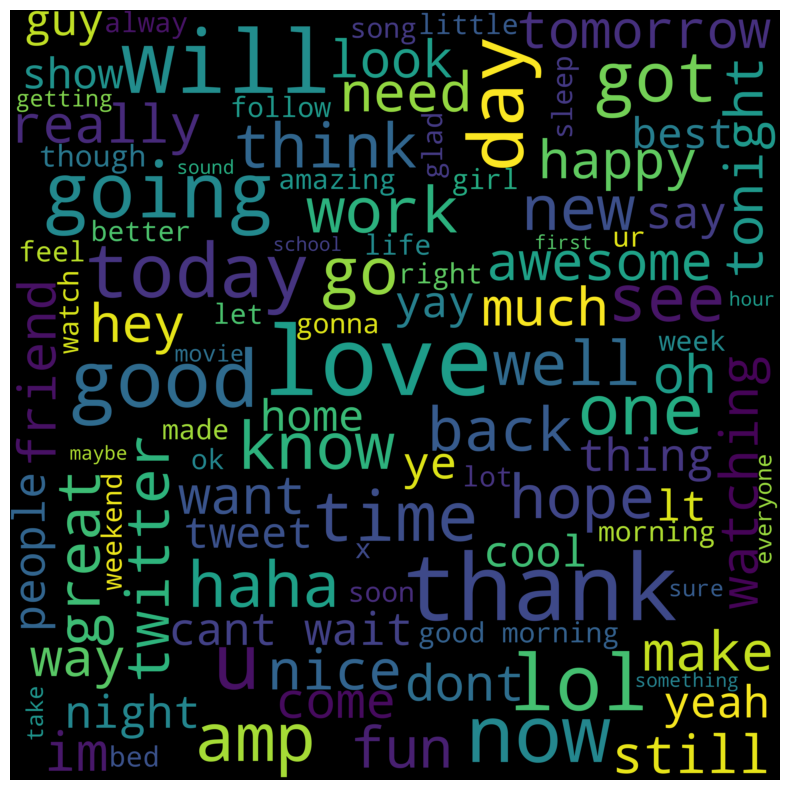

Negative Cloud


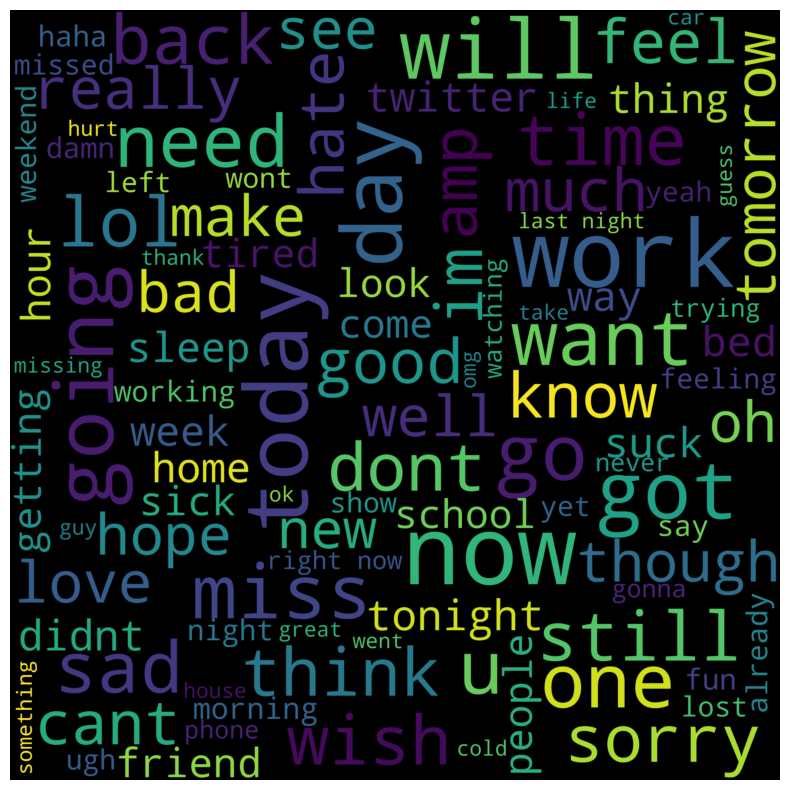

In [5]:
from wordcloud import WordCloud #Word visualization
import matplotlib.pyplot as plt

def get_word_cloud(df):
        positive_tweets = df[df["sentiment_label"] == 4]['tweet_text_processed'].astype(str)
        negative_tweets = df[df["sentiment_label"] == 0]['tweet_text_processed'].astype(str)
        draw_word_cloud(positive_tweets,  sentiment_type = 1)
        draw_word_cloud(negative_tweets,  sentiment_type = 0)
        # Joining all positive tweets into a single string without spaces
        
def draw_word_cloud(tweets, sentiment_type):
        word_cloud_text = ' '.join(tweets)

        #Creation of wordcloud
        wordcloud = WordCloud(
        max_font_size=100,
        max_words=100,
        background_color="black",
        scale=10,
        width=800,
        height=800
        ).generate(word_cloud_text)
        #Figure properties
        plt.figure(figsize=(10,10))
        plt.imshow(wordcloud, interpolation="bilinear")
        if sentiment_type == 1:
                print('Positive Cloud')
        else: 
                print('Negative Cloud')
        plt.axis("off")
        plt.show()
       

get_word_cloud(df)

## Regular Methods:

Training and evaluating Logistic Regression...
Accuracy for Logistic Regression: 0.7841595941248317


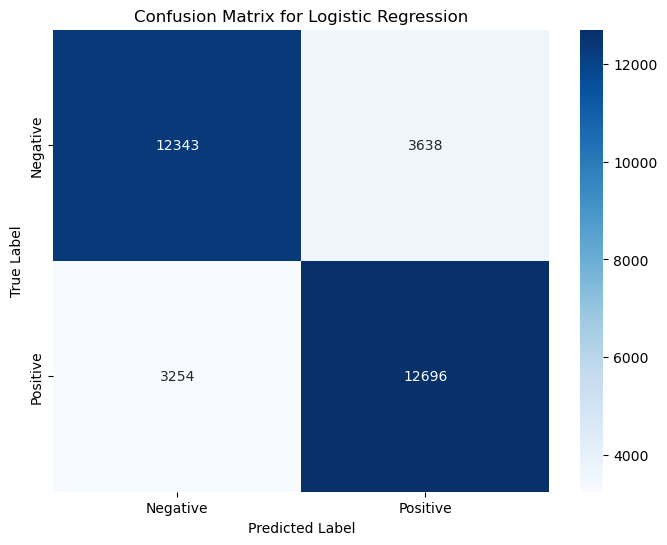

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78     15981
           1       0.78      0.80      0.79     15950

    accuracy                           0.78     31931
   macro avg       0.78      0.78      0.78     31931
weighted avg       0.78      0.78      0.78     31931

--------------------------------------------------
Training and evaluating Multinomial Naive Bayes...
Accuracy for Multinomial Naive Bayes: 0.7707556919607904


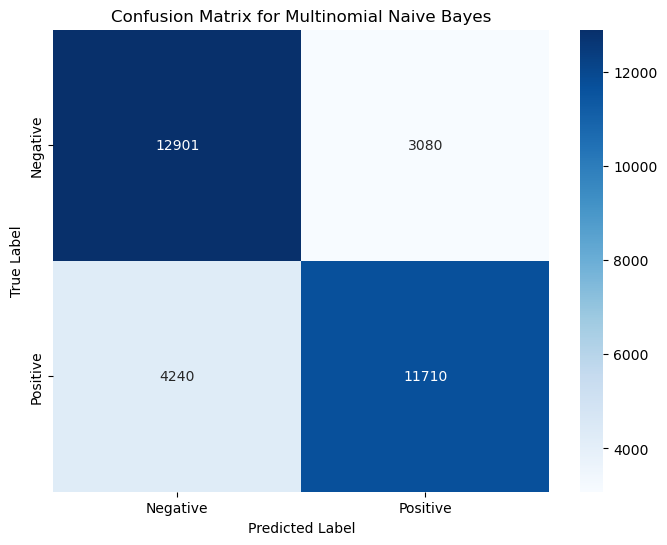

Classification Report for Multinomial Naive Bayes:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78     15981
           1       0.79      0.73      0.76     15950

    accuracy                           0.77     31931
   macro avg       0.77      0.77      0.77     31931
weighted avg       0.77      0.77      0.77     31931

--------------------------------------------------
Training and evaluating XGBoost...
Accuracy for XGBoost: 0.7617049262472205


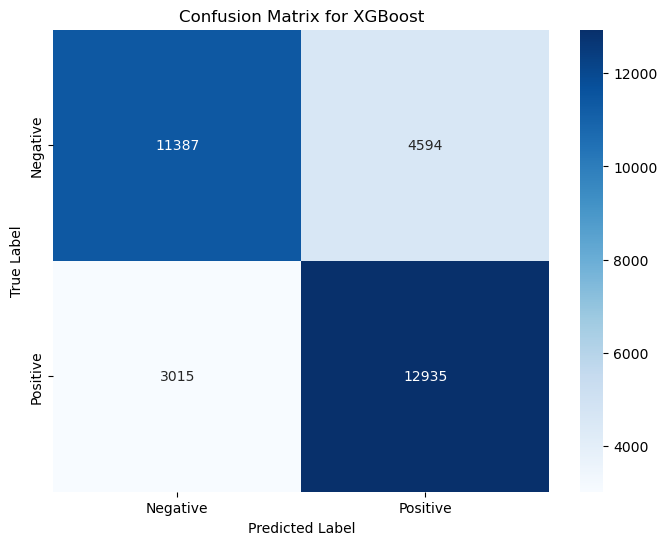

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     15981
           1       0.74      0.81      0.77     15950

    accuracy                           0.76     31931
   macro avg       0.76      0.76      0.76     31931
weighted avg       0.76      0.76      0.76     31931

--------------------------------------------------


In [6]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

def train_evaluate_model(model_name, model, X_train, y_train, X_test, y_test):

    print(f"Training and evaluating {model_name}...")
    model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    print(f'Accuracy for {model_name}: {accuracy}')

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Classification report
    print(f'Classification Report for {model_name}:\n{classification_report(y_test, predictions)}')
    print('-' * 50)

def test_and_evaluate_models(df):
    models = {
        'Logistic Regression': LogisticRegression(C=1, solver="liblinear", max_iter=1000),
        'Multinomial Naive Bayes': MultinomialNB(),
        # 'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier()
    }
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(df['tweet_text_processed'], df['sentiment_label'], test_size=0.2, random_state=42)

    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Use CountVectorizer to convert text to numerical features
    vectorizer = CountVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)

    # Train and evaluate each model sequentially
    for model_name, model in models.items():
        train_evaluate_model(model_name, model, X_train_vectorized, y_train_encoded, X_test_vectorized, y_test_encoded)

# Train General Models
test_and_evaluate_models(df)


## BERT + LSTM

if you want to test GPT2 etc., please clone [Repo](https://github.com/lunapapa-finland/EDISS-NLP)

In [7]:
import torch
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import LabelEncoder


# PyTorch dataset for text vectorization
class TextDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        encoding = self.tokenizer(
            item["tweet_text"],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        sentiment_label = item['sentiment_label']
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'sentiment_label': sentiment_label}


# Tokenization using Hugging Face tokenizer
def tokenize_with_huggingface(data):
    
    max_length = data["tweet_text_processed"].apply(lambda x: len(x.split())).max()
    
    print(f"Number of Tokenized features are {max_length}")
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    # Get the vocabulary size
    vocab_size = tokenizer.vocab_size
    tokenized_data = tokenizer(
        [row["tweet_text_processed"] for _, row in data.iterrows()],
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    # Encode sentiment labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(data["sentiment_label"])

    # Add encoded labels to the tokenized data
    tokenized_data["sentiment_label"] = encoded_labels

    return tokenized_data, vocab_size


#Tokenizing
tokenized_data, vocab_size = tokenize_with_huggingface(df)

Number of Tokenized features are 40


## BERT+LSTM

For GPT2, you can check the implementation in the [Repo](https://github.com/lunapapa-finland/EDISS-NLP)

embed_size:1024
hidden_size:1024
output_size:1
batch_size:8
learning_rate:0.001


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.5451, Accuracy: 71.17%


Epochs:  10%|█         | 1/10 [02:40<24:07, 160.85s/it]

Epoch [1/10], Validation Loss: 0.4850, Validation Accuracy: 77.40%


Epoch [2/10], Loss: 0.4435, Accuracy: 79.74%


Epochs:  20%|██        | 2/10 [05:21<21:24, 160.57s/it]

Epoch [2/10], Validation Loss: 0.4585, Validation Accuracy: 78.82%


Epoch [3/10], Loss: 0.4043, Accuracy: 82.05%


Epochs:  30%|███       | 3/10 [08:01<18:42, 160.32s/it]

Epoch [3/10], Validation Loss: 0.4518, Validation Accuracy: 79.14%


Epoch [4/10], Loss: 0.3747, Accuracy: 83.73%


Epochs:  40%|████      | 4/10 [10:41<16:01, 160.28s/it]

Epoch [4/10], Validation Loss: 0.4616, Validation Accuracy: 78.77%


Epoch [5/10], Loss: 0.3518, Accuracy: 84.84%


Epochs:  50%|█████     | 5/10 [13:21<13:21, 160.23s/it]

Epoch [5/10], Validation Loss: 0.4815, Validation Accuracy: 78.59%


Epoch [6/10], Loss: 0.3333, Accuracy: 85.81%


Epochs:  60%|██████    | 6/10 [16:01<10:40, 160.17s/it]

Epoch [6/10], Validation Loss: 0.4812, Validation Accuracy: 78.66%


Epoch [7/10], Loss: 0.3195, Accuracy: 86.45%


Epochs:  70%|███████   | 7/10 [18:41<08:00, 160.14s/it]

Epoch [7/10], Validation Loss: 0.4929, Validation Accuracy: 78.46%


Epoch [8/10], Loss: 0.3075, Accuracy: 86.98%


Epochs:  80%|████████  | 8/10 [21:21<05:20, 160.16s/it]

Epoch [8/10], Validation Loss: 0.5074, Validation Accuracy: 78.26%


Epoch [9/10], Loss: 0.3010, Accuracy: 87.34%


Epochs:  90%|█████████ | 9/10 [24:01<02:40, 160.10s/it]

Epoch [9/10], Validation Loss: 0.5152, Validation Accuracy: 78.23%


Epoch [10/10], Loss: 0.2953, Accuracy: 87.61%


Epochs: 100%|██████████| 10/10 [26:41<00:00, 160.18s/it]


Epoch [10/10], Validation Loss: 0.5152, Validation Accuracy: 78.53%


Testing: 100%|██████████| 1996/1996 [00:04<00:00, 433.15it/s]


Test Loss: 0.5156, Test Accuracy: 78.08%


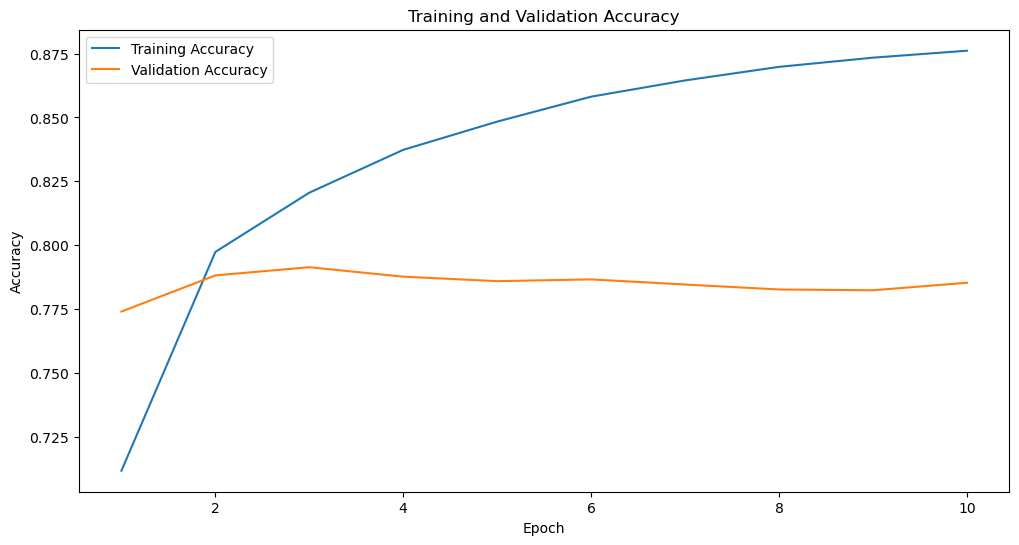

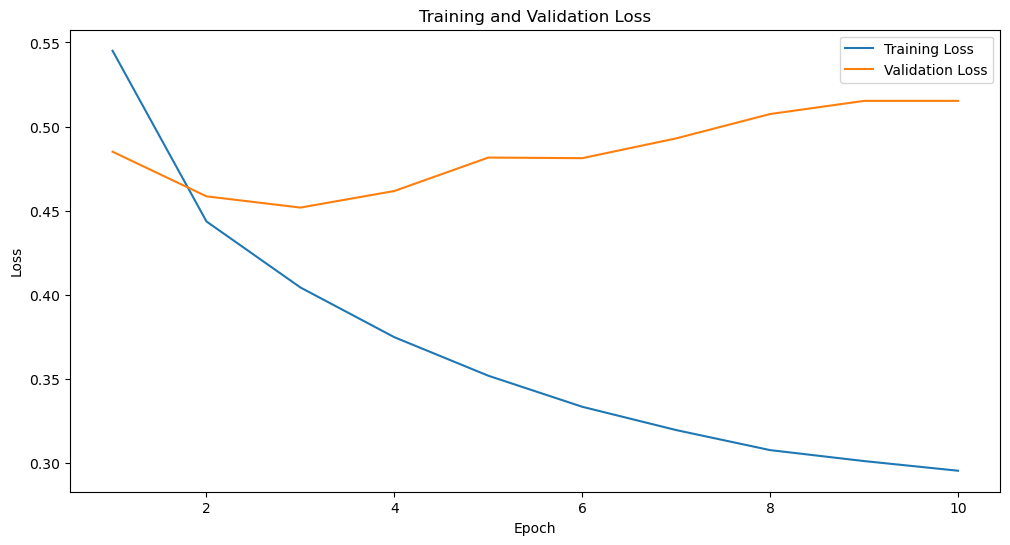

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask, token_type_ids):
        embedded = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embedded)
        output = self.fc(lstm_out[:, -1, :])
        output = self.sigmoid(output)
        return output

# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        input_ids = self.data['input_ids'][index]
        attention_mask = self.data['attention_mask'][index]
        token_type_ids = self.data['token_type_ids'][index]
        sentiment_label = self.data['sentiment_label'][index]
        
        return input_ids, attention_mask, token_type_ids, sentiment_label
    
def plot_accuracy(epochs_range, train_accuracy_history, val_accuracy_history):
    # Accuracy plot
    plt.figure(figsize=(12, 6))
    plt.plot(epochs_range, train_accuracy_history, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
def plot_loss(epochs_range, train_loss_history, val_loss_history):
    # Loss plot
    plt.figure(figsize=(12, 6))
    plt.plot(epochs_range, train_loss_history, label='Training Loss')
    plt.plot(epochs_range, val_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def train_validate_test_LSTM(tokenized_data, vocab_size):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Hyperparameters
    vocab_size = vocab_size  # Assuming you are using the base model of BERT, adjust based on your tokenizer
    embed_size = 1024
    hidden_size = 1024
    output_size = 1
    num_epochs = 10
    batch_size = 8
    learning_rate = 0.001
    val_threshold = 0.8
    test_threshold = 0.9
    torch.manual_seed(42)
    
    print(f'embed_size:{embed_size}')
    print(f'hidden_size:{hidden_size}')
    print(f'output_size:{output_size}')
    print(f'batch_size:{batch_size}')
    print(f'learning_rate:{learning_rate}')

    

    
    # Initialize model, loss function, and optimizer
    model = LSTMModel(vocab_size, embed_size, hidden_size, output_size).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    dataset = CustomDataset(tokenized_data)
 
    
    # Split dataset into train, validation, and test sets
    dataset_size = len(tokenized_data['input_ids'])
    indices = list(range(dataset_size))
    split1 = int(np.floor(val_threshold * dataset_size))  
    split2 = int(np.floor(test_threshold * dataset_size))  

    # Define samplers for each set
    train_sampler = SubsetRandomSampler(indices[:split1])
    val_sampler = SubsetRandomSampler(indices[split1:split2])
    test_sampler = SubsetRandomSampler(indices[split2:])

    # Prepare data loaders for each set
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    
    best_val_loss = float('inf')
    best_model_state = None
    
    # Lists to store training statistics for plotting
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []

    # Training loop
    for epoch in tqdm(range(num_epochs), desc=f'Epochs'):
        model.train()  # Set the model to training mode
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            input_ids, attention_mask, token_type_ids, labels = [tensor.to(device) for tensor in batch]

            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(input_ids, attention_mask, token_type_ids)
            # Calculate the loss
            loss = criterion(outputs.squeeze(), labels.float())  # Squeeze to remove extra dimensions
            # Backward pass
            loss.backward()
            # Update weights
            optimizer.step()
            total_loss += loss.item()
            
            # Calculate accuracy
            predicted = torch.round(outputs).squeeze()
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
                  
        avg_loss = total_loss / len(train_loader)
        accuracy = correct_predictions / total_samples
        # Save training statistics for plotting
        train_loss_history.append(avg_loss)
        train_accuracy_history.append(accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

        
        # Validation loop
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0

        with torch.no_grad():
            for val_batch in tqdm(val_loader, desc=f'Validation', leave=False):
                val_input_ids, val_attention_mask, val_token_type_ids, val_labels = [tensor.to(device) for tensor in val_batch]

                # Forward pass (no backward pass during validation)
                val_outputs = model(val_input_ids, val_attention_mask, val_token_type_ids)
                # Calculate the validation loss
                val_loss = criterion(val_outputs.squeeze(), val_labels.float())
                total_val_loss += val_loss.item()

                # Calculate validation accuracy
                val_predicted = torch.round(val_outputs).squeeze()
                correct_val_predictions += (val_predicted == val_labels).sum().item()
                total_val_samples += val_labels.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val_predictions / total_val_samples
        # Save validation statistics for plotting
        val_loss_history.append(avg_val_loss)
        val_accuracy_history.append(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%')

        # Save the best model based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            # torch.save(model.state_dict(), os.path.join(parameters['model_path'],f'best_model_epoch_{epoch+1}.pth'))
            
            
    # Load the best model state
    model.load_state_dict(best_model_state)

    # Testing loop
    model.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    correct_test_predictions = 0
    total_test_samples = 0
    with torch.no_grad():
        for test_batch in tqdm(test_loader, desc=f'Testing'):
            test_input_ids, test_attention_mask, test_token_type_ids, test_labels = [tensor.to(device) for tensor in test_batch]

            # Forward pass (no backward pass during validation)
            test_outputs = model(test_input_ids, test_attention_mask, test_token_type_ids)
            # Calculate the validation loss
            test_loss = criterion(test_outputs.squeeze(), test_labels.float())
            total_test_loss += test_loss.item()

            # Calculate validation accuracy
            test_predicted = torch.round(test_outputs).squeeze()
            correct_test_predictions += (test_predicted == test_labels).sum().item()
            total_test_samples += test_labels.size(0)
            
    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = correct_test_predictions / total_test_samples
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')

    # Plotting
    epochs_range = range(1, num_epochs + 1)
    plot_accuracy(epochs_range, train_accuracy_history, val_accuracy_history)
    plot_loss(epochs_range, train_loss_history, val_loss_history)

train_validate_test_LSTM(tokenized_data, vocab_size)